In [19]:
# ==================== SETUP PATH & IMPORTS ====================
import sys
import os
import numpy as np
import pandas as pd
import torch
from pathlib import Path

# Set random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Add project root to path (notebook is in notebooks/)
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✓ Project Root: {PROJECT_ROOT}")
print(f"✓ Python path configured")

✓ Project Root: e:\Capstone_FA25
✓ Python path configured


In [20]:
# ==================== IMPORT PROJECT MODULES ====================
from src.models import Actor
from src.environments import HVACEnvironment
from src.visualization import plot_evaluation_results, print_comfort_statistics
from configs.config_manager import get_eval_config

print("✓ All project modules imported successfully!")

✓ All project modules imported successfully!


## 1. Configuration

Chọn chế độ evaluation và đường dẫn files.

In [21]:
# ==================== CONFIGURATION ====================
# Chọn mode: True = với forecast (state_dim=15), False = không forecast (state_dim=14)
USE_FORECAST = True

# Get config từ config_manager
config = get_eval_config(use_forecast=USE_FORECAST)

# Override paths nếu cần (uncomment và thay đổi)
config.FMU_PATH = str(PROJECT_ROOT / "HVAC.fmu")
config.WEATHER_CSV = r"E:\Capstone_FA25\data\test\North_hot_FC.csv"  # Thay đổi path

# Checkpoint path
CHECKPOINT_PATH = r"E:\Capstone_FA25\checkpoints\with_forecast\checkpoints_North_hot_FC\best_model.pth"  # Thay đổi path

# Results directory
RESULTS_DIR = PROJECT_ROOT / "results" / "evaluation" / ("forecast" if USE_FORECAST else "no_forecast") / Path(config.WEATHER_CSV).stem
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Display config
config.display()
print(f"\n📁 Paths:")
print(f"   FMU:        {config.FMU_PATH}")
print(f"   Weather:    {config.WEATHER_CSV}")
print(f"   Checkpoint: {CHECKPOINT_PATH}")
print(f"   Results:    {RESULTS_DIR}")

                    Configuration - WITH FORECAST                     
Device:           cuda
State Dim:        15 (with forecast)
Action Dim:       5
Hidden Dim:       512
Actor LR:         1.00e-04
Critic LR:        3.00e-04
Batch Size:       512
Buffer Capacity:  200000
Episodes:         50
Save Frequency:   2
Checkpoint Path:  e:\Capstone_FA25\checkpoints\with_forecast

📁 Paths:
   FMU:        e:\Capstone_FA25\HVAC.fmu
   Weather:    E:\Capstone_FA25\data\test\North_hot_FC.csv
   Checkpoint: E:\Capstone_FA25\checkpoints\with_forecast\checkpoints_North_hot_FC\best_model.pth
   Results:    e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC


## 2. Policy Wrapper

Wrapper đơn giản sử dụng `Actor` từ `src.models`.

In [22]:
# ==================== POLICY WRAPPER ====================
class PolicyWrapper:
    """Simple wrapper using Actor from src.models"""
    
    def __init__(self, state_dim, action_dim, hidden_dim, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(self.device)
        print(f"✓ PolicyWrapper initialized on {self.device}")
    
    def load_actor(self, checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=self.device)
        self.actor.load_state_dict(ckpt['actor'])
        self.actor.eval()
        print(f"✓ Loaded actor from: {checkpoint_path}")
        if 'total_steps' in ckpt:
            print(f"  Training steps: {ckpt['total_steps']}")
    
    def select_action(self, state):
        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state_t).cpu().numpy()[0]
        return action

## 3. Initialize Environment & Policy

In [23]:
# ==================== INITIALIZE ====================
print("="*70)
print("🔧 INITIALIZING ENVIRONMENT & POLICY")
print("="*70 + "\n")

# Initialize Environment từ src.environments
env = HVACEnvironment(config, verbose=True)

# Initialize Policy với Actor từ src.models
policy = PolicyWrapper(
    state_dim=config.STATE_DIM, 
    action_dim=config.ACTION_DIM,
    hidden_dim=config.HIDDEN_DIM,
    device=config.DEVICE
)
policy.load_actor(CHECKPOINT_PATH)

print("\n✅ Initialization complete!")

🔧 INITIALIZING ENVIRONMENT & POLICY

✓ Running WITH forecast (state_dim=15)
✓ PolicyWrapper initialized on cuda
✓ Loaded actor from: E:\Capstone_FA25\checkpoints\with_forecast\checkpoints_North_hot_FC\best_model.pth
  Training steps: 83506

✅ Initialization complete!


## 4. Run Evaluation

In [24]:
# ==================== RUN EVALUATION ====================
# Reset environment (includes warmup)
state = env.reset()

# Initialize logging
done = False
step_count = 0
cumulative_reward = 0.0

log = {
    "time_hours": [], "T_zone_C": [], "RH_zone": [], "CO2_ppm": [],
    "P_total_kW": [], "reward": [], "uFan": [], "uOA": [],
    "uChiller": [], "uHeater": [], "uFanEA": [], "T_outdoor": [], "RH_outdoor": []
}

print("\n" + "="*70)
print("🚀 EVALUATION (NO NOISE, GREEDY POLICY)")
print("="*70 + "\n")

# Main loop
while not done:
    action = policy.select_action(state)
    next_state, reward, done, info = env.step(action)

    cumulative_reward += reward
    step_count += 1
    t_hours = (env.current_t - env.main_start) / 3600.0

    if info:
        log["time_hours"].append(t_hours)
        log["T_zone_C"].append(info["T_zone"])
        log["RH_zone"].append(info["RH_zone"])
        log["CO2_ppm"].append(info["CO2"])
        log["P_total_kW"].append(info["P_total"] / 1000.0)
        log["reward"].append(reward)
        log["uFan"].append(info["uFan"])
        log["uOA"].append(info["uOA"])
        log["uChiller"].append(info["uChiller"])
        log["uHeater"].append(info["uHeater"])
        log["uFanEA"].append(info["uFanEA"])
        log["T_outdoor"].append(info.get("T_outdoor", np.nan))
        log["RH_outdoor"].append(info.get("RH_outdoor", np.nan))

    if step_count % 100 == 0:
        print(f"Step {step_count:04d} | t={t_hours:7.2f}h | "
              f"T={log['T_zone_C'][-1]:5.2f}°C | RH={log['RH_zone'][-1]:.3f} | "
              f"P={log['P_total_kW'][-1]:5.2f}kW | r={reward:.3f}")

    state = next_state

print("\n✅ Evaluation loop completed!")

=== Warmup Phase (7 days) ===
Final Run Statistics: --- 

 Number of steps                                 : 1264
 Number of function evaluations                  : 1535
 Number of Jacobian evaluations                  : 41
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 27
 Number of nonlinear iterations                  : 1534
 Number of nonlinear convergence failures        : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 604800.0 seconds.
Elapsed simulation time: 0.30297150000114925 seconds.
✓ Warmup completed at t = 168.00 hours

🚀 EVALUATION (NO NOISE, GREEDY POLICY)

Final Run Statistics: --- 

 Number of steps                                 : 313
 Number of function evaluations          

## 5. Save Results

In [25]:
# ==================== SAVE RESULTS ====================
avg_reward = cumulative_reward / max(step_count, 1)

print("\n" + "="*70)
print("📋 EVALUATION SUMMARY")
print("="*70)
print(f"  Total Steps:      {step_count}")
print(f"  Total Reward:     {cumulative_reward:.3f}")
print(f"  Avg Reward/Step:  {avg_reward:.5f}")
print("="*70)

# Save to DataFrame
eval_df = pd.DataFrame(log)

# Save CSV
csv_path = RESULTS_DIR / "eval_run_data.csv"
eval_df.to_csv(csv_path, index=False)
print(f"\n✓ Data saved: {csv_path}")

eval_df.head(10)


📋 EVALUATION SUMMARY
  Total Steps:      5849
  Total Reward:     20723.308
  Avg Reward/Step:  3.54305

✓ Data saved: e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC\eval_run_data.csv


time_hours   T_zone_C   RH_zone     CO2_ppm  P_total_kW    reward  uFan  \
0        0.25  26.397552  0.642140  540.265365    1.110626  2.463690   0.1   
1        0.50  26.279689  0.602513  556.709386    0.774018  3.015844   0.1   
2        0.75  26.318589  0.629681  568.003239    0.745442  3.043880   0.1   
3        1.00  26.374771  0.661224  575.623817    0.743538  3.045771   0.1   
4        1.25  26.318825  0.660252  580.739773    0.742756  3.246778   0.1   
5        1.50  26.198860  0.643916  584.255537    0.741747  3.247823   0.1   
6        1.75  26.088206  0.631964  586.674099    0.740320  3.249219   0.1   
7        2.00  25.981030  0.623865  588.547483    0.739096  3.250383   0.1   
8        2.25  25.892478  0.619097  589.733350    0.738722  3.250730   0.1   
9        2.50  25.788495  0.614526  590.709185    0.738877  3.250585   0.1   

        uOA  uChiller   uHeater  uFanEA  T_outdoor  RH_outdoor  
0  0.829325  0.999993  0.081918     0.7     27.550      0.8650  
1  0.826396  0.999997  0.014224     0.7     27.500      0.8600  
2  0.771165  0.999999  0.001600     0.7     27.450      0.8550  
3  0.729116  0.999998  0.001653     0.7     27.400      0.8500  
4  0.710329  0.999997  0.001943     0.7     27.375      0.8450  
5  0.715082  0.999996  0.001872     0.7     27.350      0.8400  
6  0.718314  0.999996  0.001593     0.7     27.325      0.8350  
7  0.718084  0.999995  0.001463     0.7     27.300      0.8300  
8  0.716468  0.999995  0.001534     0.7     27.300      0.8275  
9  0.715979  0.999994  0.001635     0.7     27.300      0.8250

## 6. Comfort Statistics

Sử dụng `print_comfort_statistics` từ `src.visualization`.

In [26]:
# ==================== COMFORT STATISTICS ====================
# Sử dụng function từ src.visualization
print_comfort_statistics(eval_df)


📊 COMFORT STATISTICS

🌡️  TEMPERATURE:
   Range:       25.5 - 28.0°C
   Mean:        26.40°C
   Std:         0.72°C
   Min/Max:     24.23 / 29.05°C
   Comfort:     89.4% (5231/5848)

💧 HUMIDITY:
   Range:       0.40 - 0.70
   Mean:        0.577
   Std:         0.038
   Min/Max:     0.425 / 1.000
   Comfort:     99.2% (5802/5848)

⚡ POWER:
   Mean:        0.95 kW
   Total:       1396.05 kWh

✅ COMBINED COMFORT: 89.3%



## 7. Generate Plots

Sử dụng `plot_evaluation_results` từ `src.visualization` để tạo 12 biểu đồ.

In [27]:
# ==================== VISUALIZATION ====================
# Sử dụng function từ src.visualization
plot_evaluation_results(eval_df, save_dir=str(RESULTS_DIR))

print(f"\n✅ All 12 plots saved to: {RESULTS_DIR}")


✅ All 12 plots saved to: e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC/

✅ All 12 plots saved to: e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC


## 8. Display Plots


🌡️ Zone Temperature:


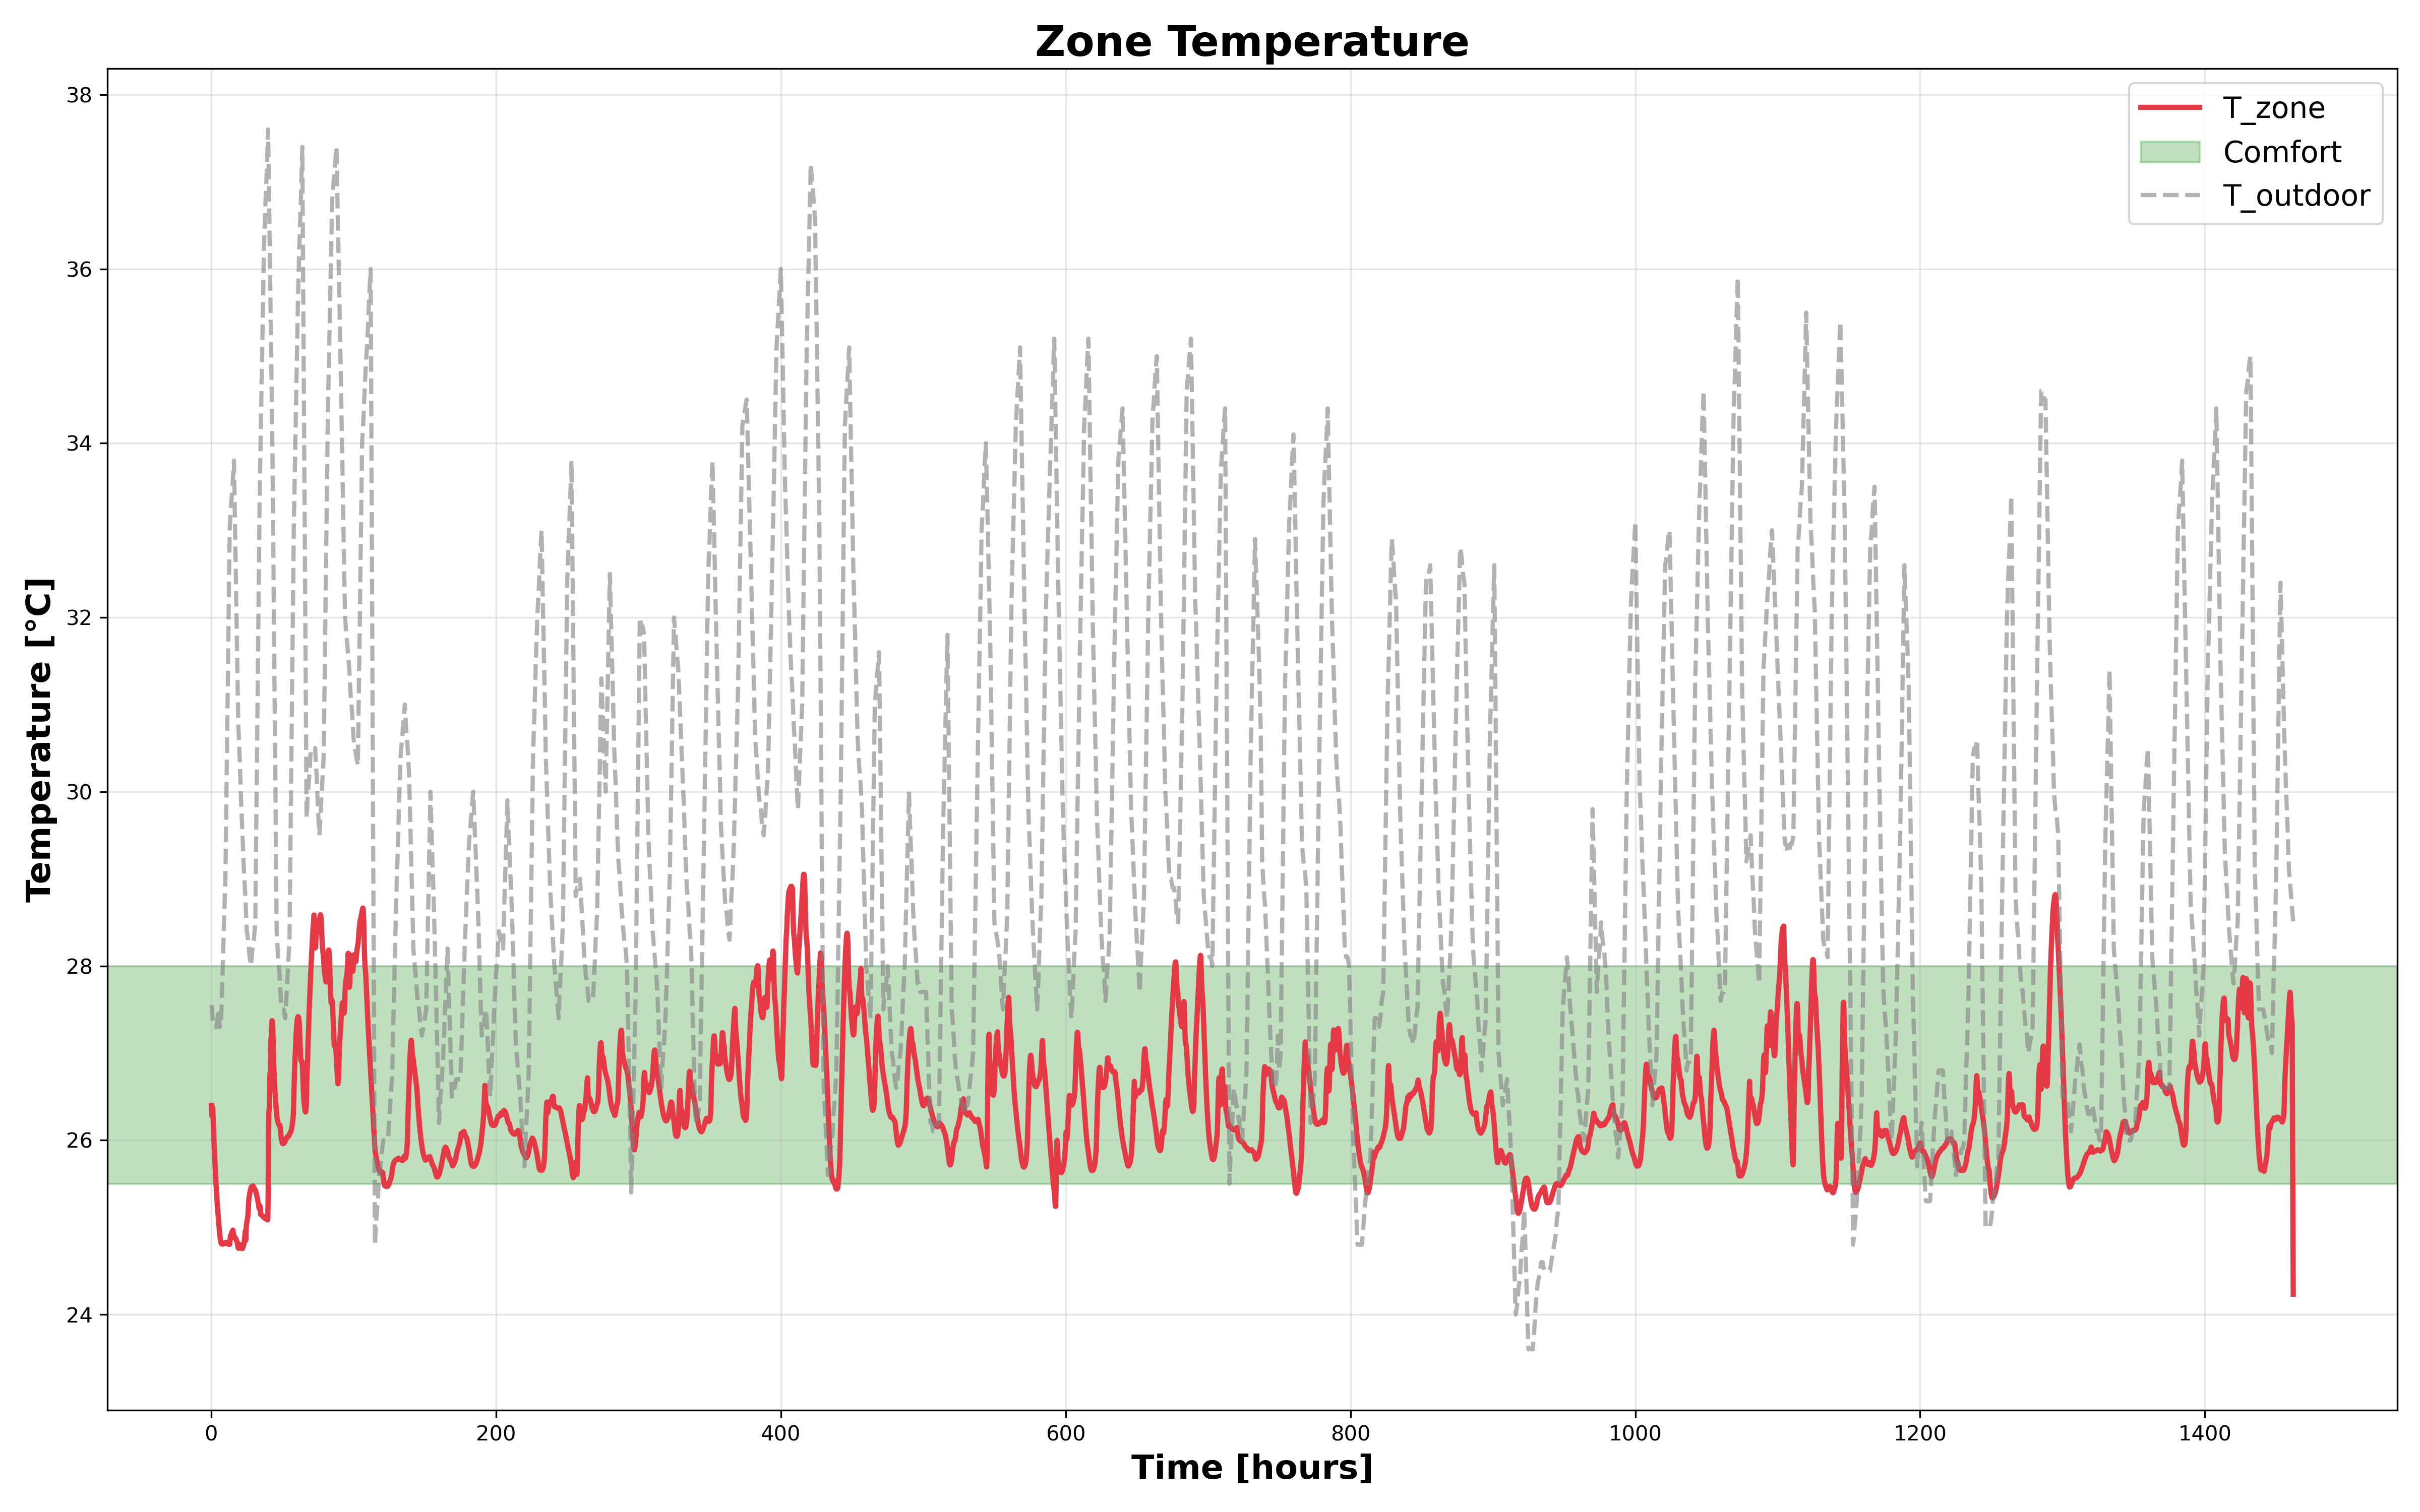


💧 Relative Humidity:


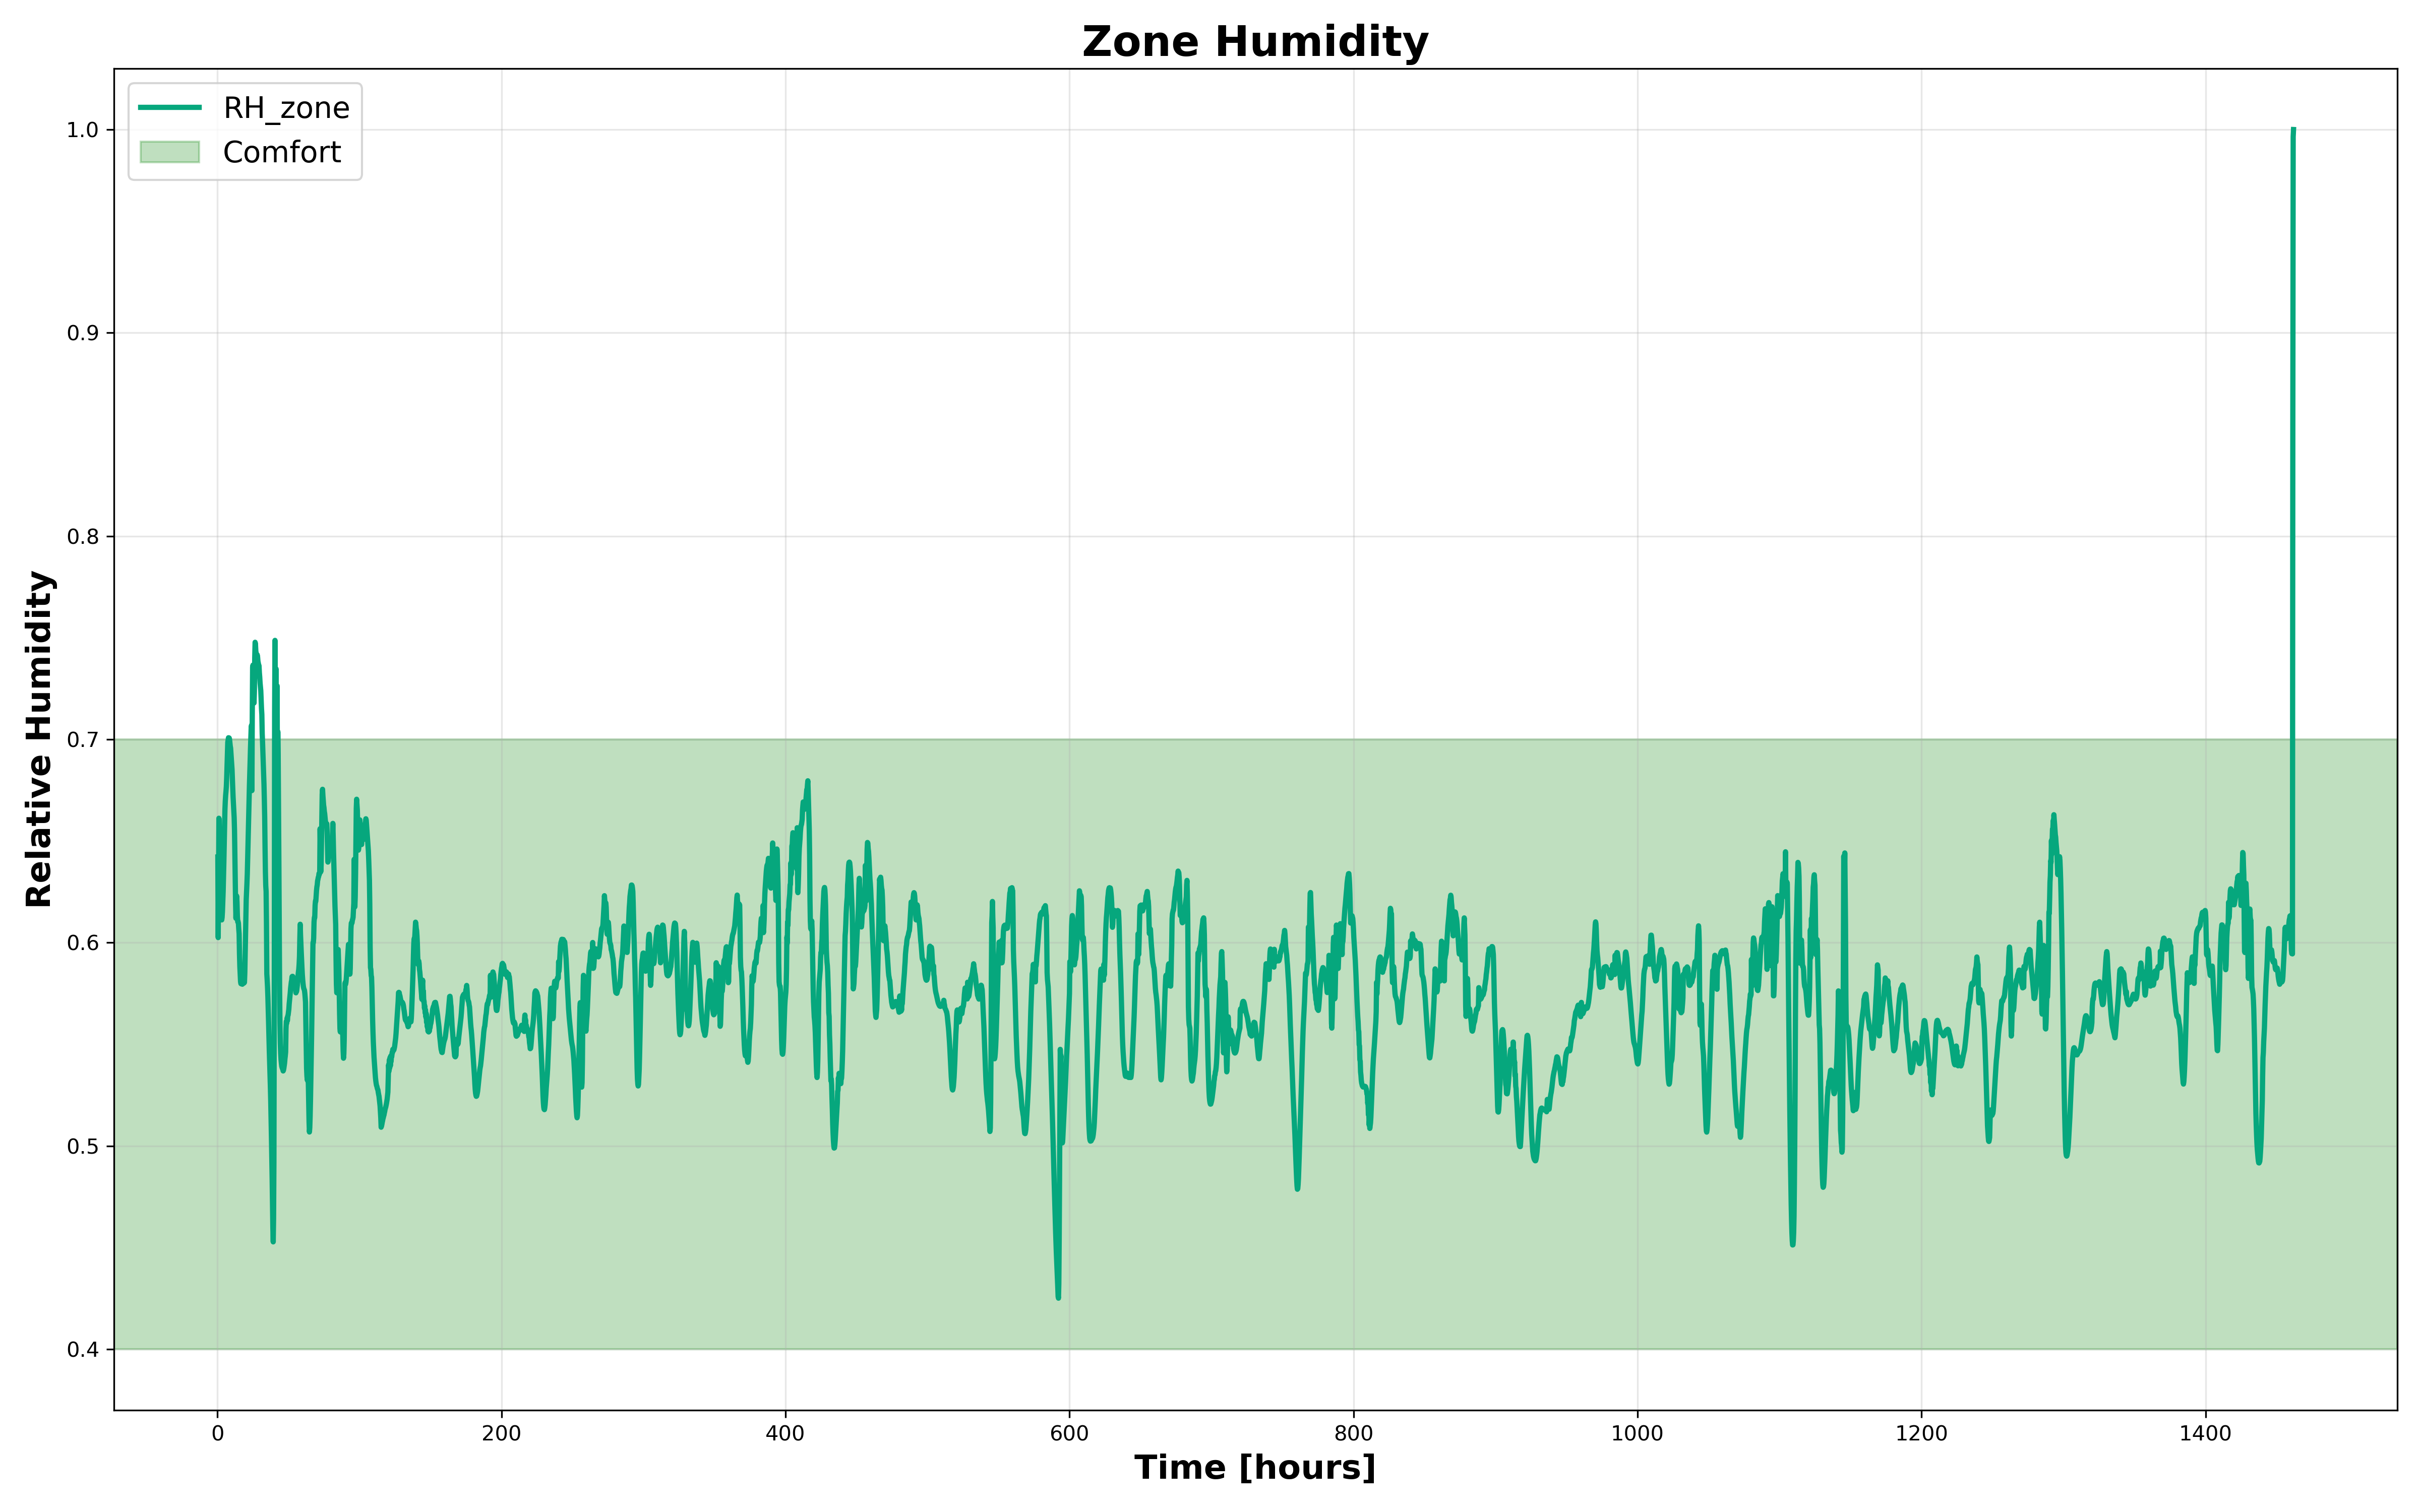


⚡ Total Power:


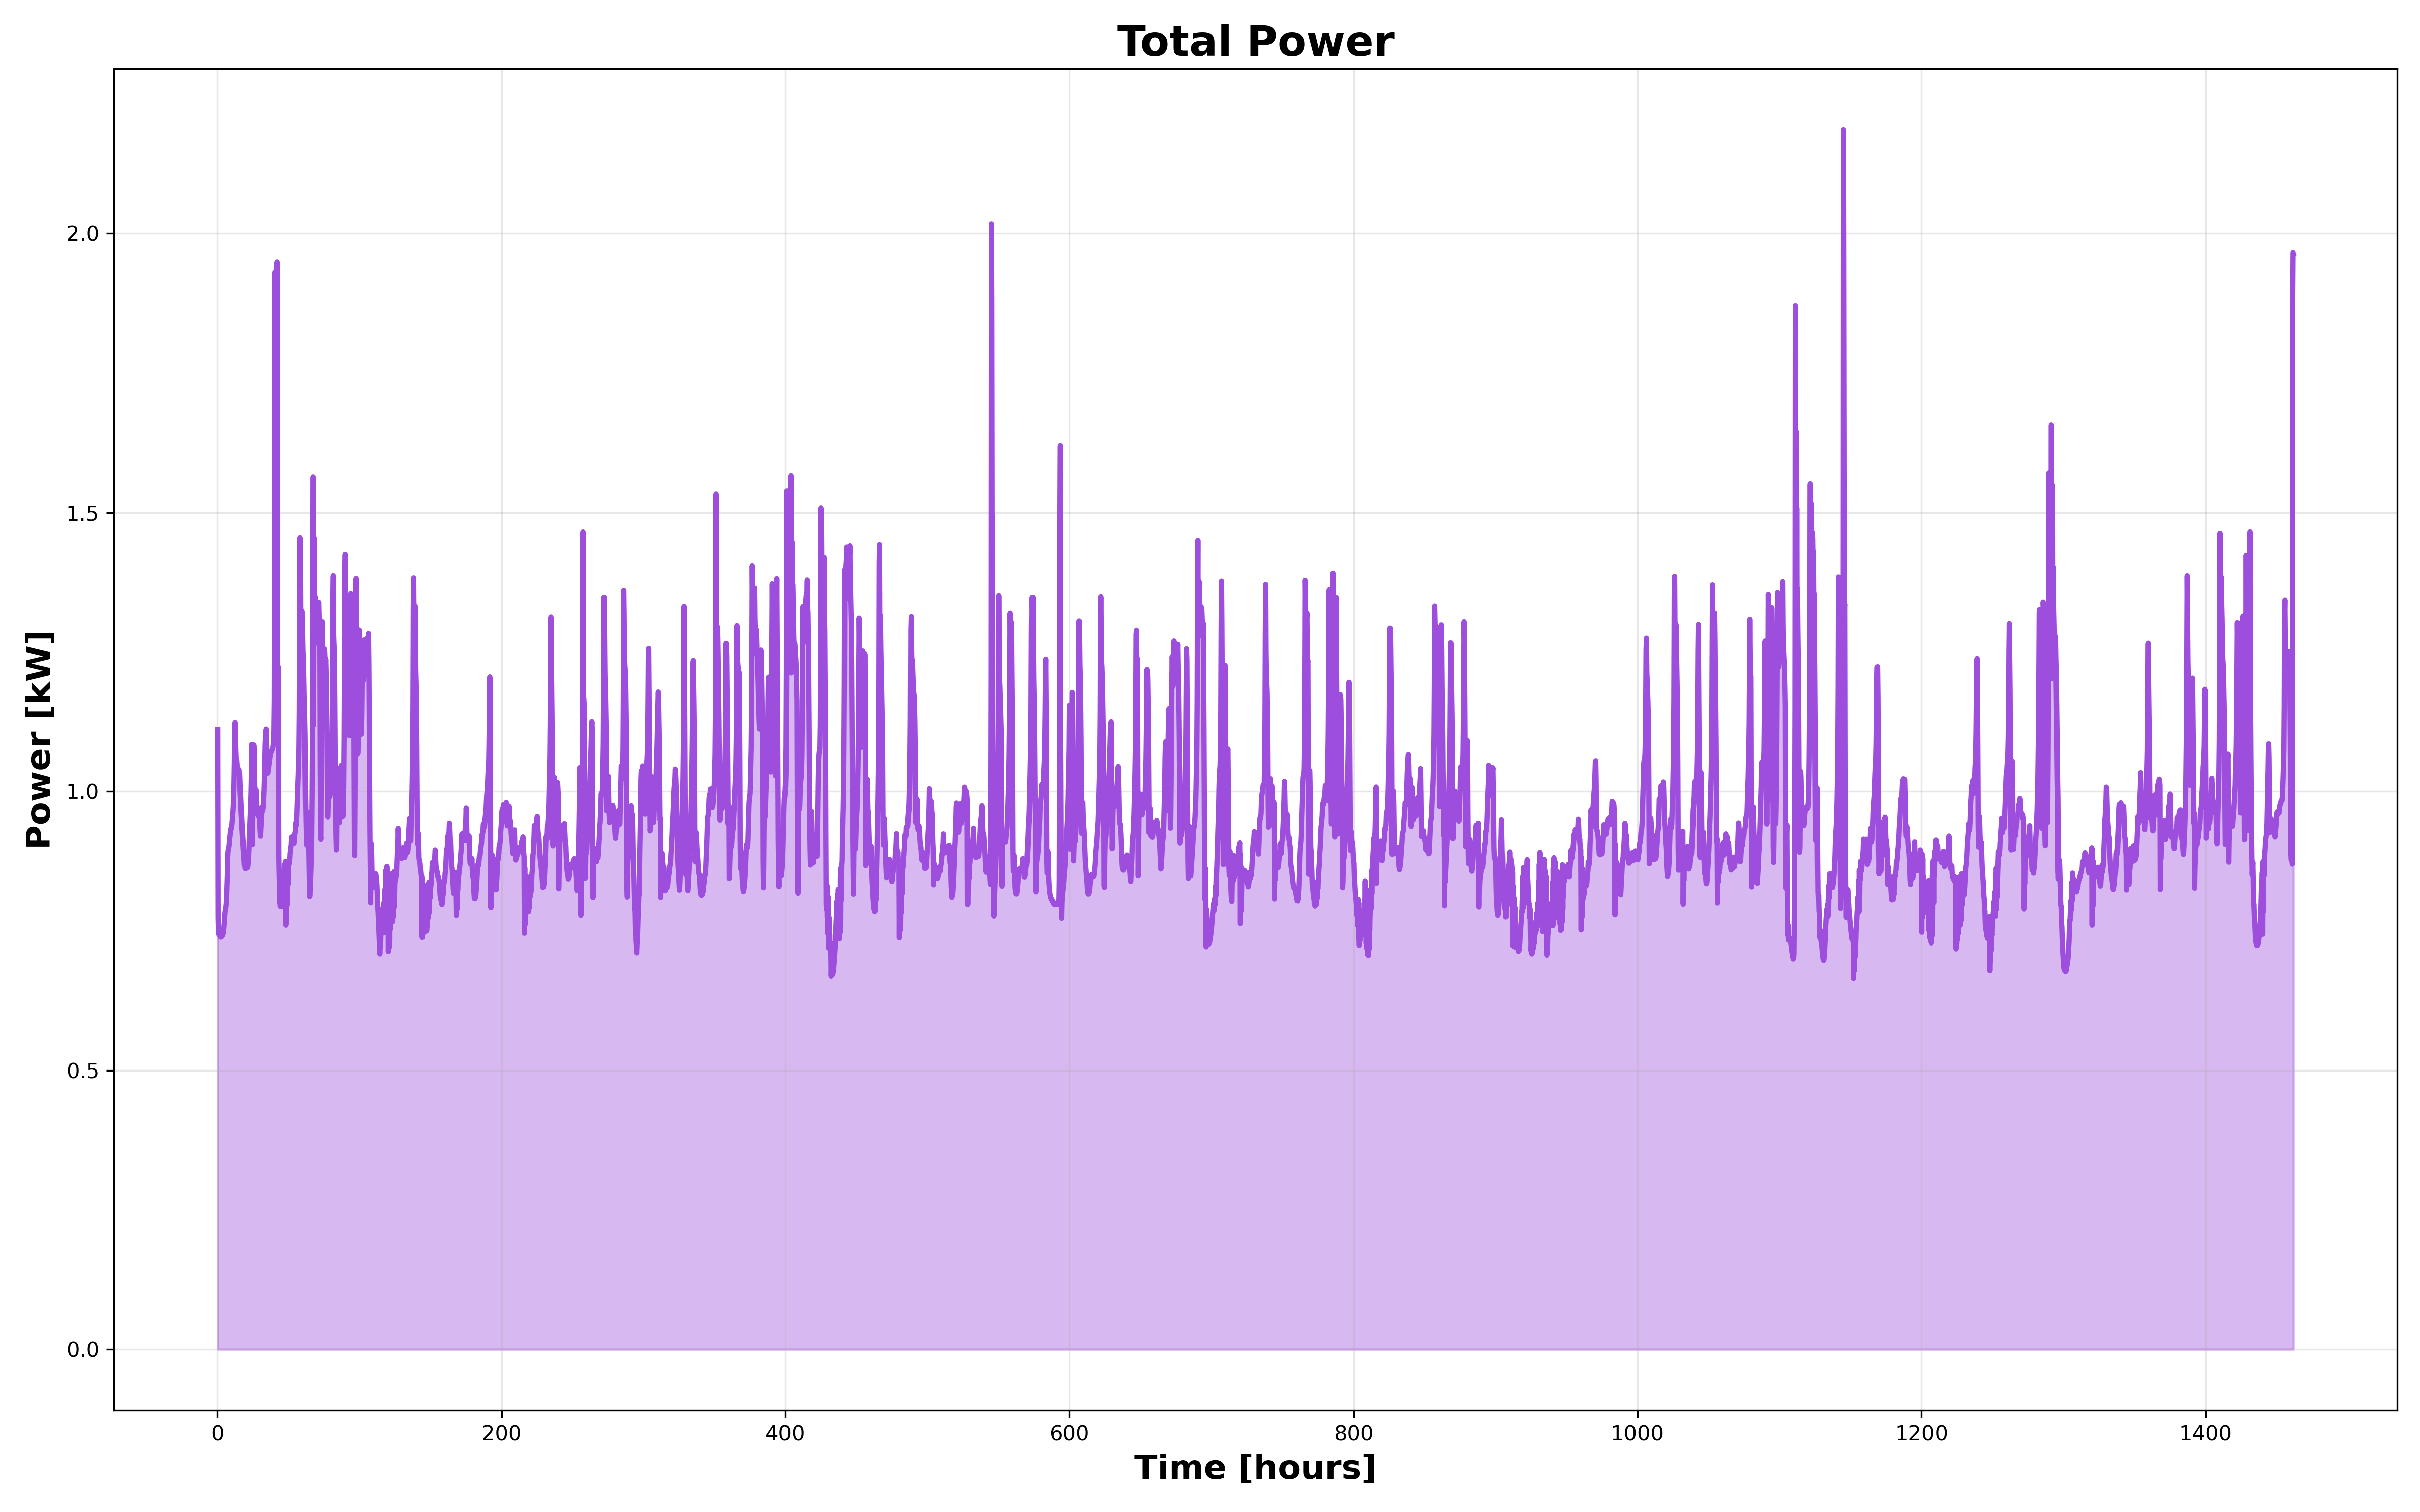


🎯 Cumulative Reward:


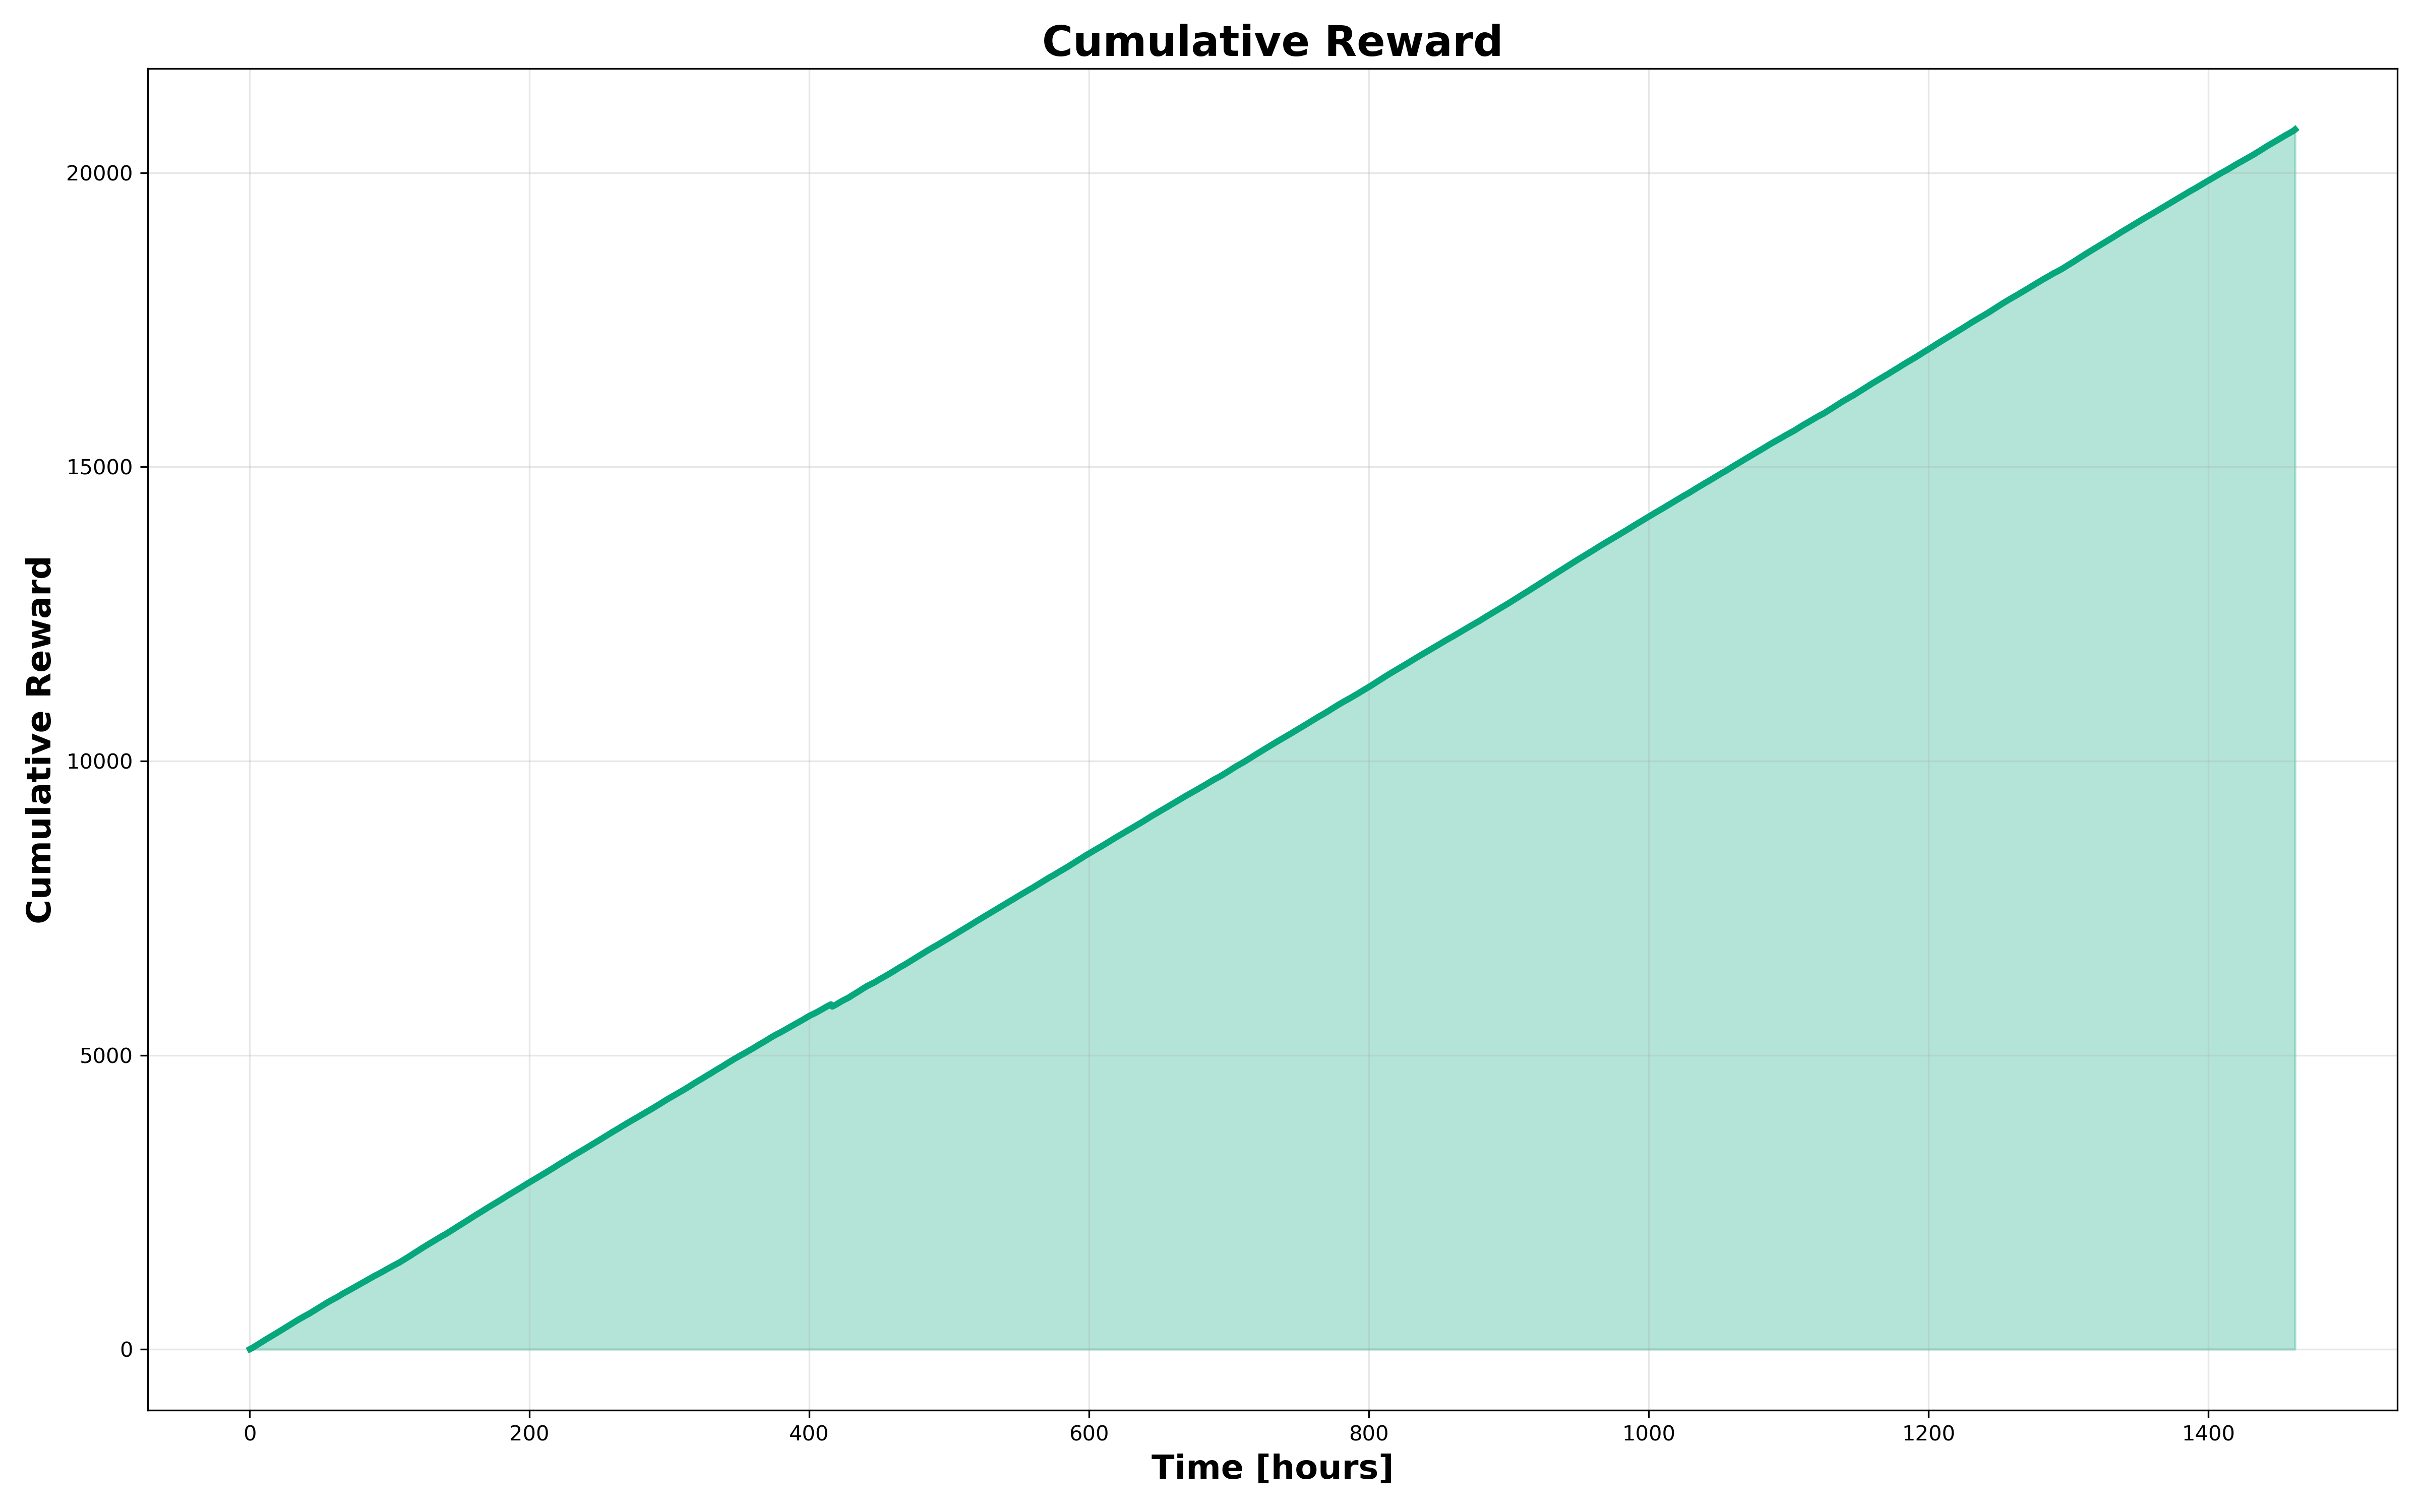

In [28]:
# ==================== DISPLAY KEY PLOTS ====================
from IPython.display import Image, display

plots_to_show = [
    ("01_zone_temperature.png", "🌡️ Zone Temperature"),
    ("02_relative_humidity.png", "💧 Relative Humidity"),
    ("04_total_power.png", "⚡ Total Power"),
    ("06_cumulative_reward.png", "🎯 Cumulative Reward")
]

for filename, title in plots_to_show:
    plot_path = RESULTS_DIR / filename
    if plot_path.exists():
        print(f"\n{title}:")
        display(Image(filename=str(plot_path), width=800))

## 9. Final Summary

In [29]:
# ==================== FINAL SUMMARY ====================
print("\n" + "="*70)
print("✅ EVALUATION COMPLETED!")
print("="*70)
print(f"\n📁 Output:")
print(f"   CSV:   {csv_path}")
print(f"   Plots: {RESULTS_DIR}/*.png")
print("\n" + "="*70)


✅ EVALUATION COMPLETED!

📁 Output:
   CSV:   e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC\eval_run_data.csv
   Plots: e:\Capstone_FA25\results\evaluation\forecast\North_hot_FC/*.png

